# Assignment 1.1

### Did you really read the text? Answer the following questions (no calculations needed) in your IPython notebook

*What's the problem with random networks as a model for real-world networks according to the argument in section 3.5 (near the end)?*

Random networks predict that everyone has nearly the same number of connections, with little variation.
In reality, some individuals have more connections than average.
This shows that random networks underestimate the spread of connections and cannot explain the presence of very highly connected people.


*List the four regimes that characterize random networks as a function of <k>.*


- **Subcritical Regime (⟨k⟩ < 1)**
  The network is mostly tiny pieces, small groups and isolated nodes. No large connected part exists.

- **Critical Point (⟨k⟩ ≈ 1)**
  This is the tipping point. A giant cluster suddenly starts to appear in the network.

- **Supercritical Regime (1 < ⟨k⟩ < ln N)**
  A big cluster exists, but some small groups and isolated nodes still remain.

- **Connected Regime (⟨k⟩ > ln N)**
  Nearly every node belongs to the same large cluster, so the network is almost fully connected.

*According to the book, why is it a problem for random networks (in terms of being a model for real-world networks) that the degree-dependent clustering C(k) decreases as a function of k in real-world networks?*

Because in real networks C(k) decreases with k, highly connected nodes link many groups together, while random networks miss this structure by predicting no such.


### WS edition


*First, let's use networkx to play around with WS graphs. Use nx.watts_strogatz_graph to generate 3 graphs with 500 nodes each, average degree = 4, and rewiring probablity P = 0, 0.1, and 1. Calculate the average shortest path length <d> for each one.*

In [1]:
import networkx as nx

n = 500 # number of nodes
k = 4 # each node is joined with its k nearest neighbors
probs = [0, 0.1, 1]

results = {}
for p in probs:
    G = nx.watts_strogatz_graph(n, k, p)
    avg_shortest_path = nx.average_shortest_path_length(G)
    results[p] = avg_shortest_path

results


{0: 62.875751503006015, 0.1: 7.572440881763527, 1: 4.7694028056112225}

*Describe what happens to the network when p = 1*

When p = 1 the network is fully randomized: every edge is rewired at random.
The graph loses its lattice structure and becomes similar to an Erdős–Rényi random graph, with very short path lengths but little local clustering.

*Generate a lot of networks with different values of p. You will notice that paths are short when p is close to one and they are long when p = 0. What's the value of p for which the average shortest path length gets close to the short paths we find in a fully randomized network.*

In [2]:
import numpy as np

# Sweep through many p values
p_values = np.logspace(-4, 0, 15)  # from 0.0001 to 1, logarithmic spacing
avg_paths = []

for p in p_values:
    G = nx.watts_strogatz_graph(n, k, p)
    avg_paths.append(nx.average_shortest_path_length(G))

# Find the smallest p where path length is within ~10% of the p=1 case
p1_value = results[1]
threshold = 1.1 * p1_value
close_idx = next(i for i, val in enumerate(avg_paths) if val <= threshold)
p_close = p_values[close_idx]


In [3]:
import pandas as pd

df = pd.DataFrame({
    "p": p_values,
    "avg_shortest_path_length": avg_paths
})

print(df)

           p  avg_shortest_path_length
0   0.000100                 62.875752
1   0.000193                 62.875752
2   0.000373                 47.820248
3   0.000720                 53.044657
4   0.001389                 50.067367
5   0.002683                 29.308673
6   0.005179                 35.771022
7   0.010000                 22.619655
8   0.019307                 20.676609
9   0.037276                 10.015479
10  0.071969                  9.275880
11  0.138950                  6.761291
12  0.268270                  5.689860
13  0.517947                  4.973747
14  1.000000                  4.783070


By generating many networks for different values of p, we see that the average shortest path length quickly drops.
It gets close to the fully randomized case (p = 1) already around **p ≈ 0.5**.

*Let's investigate this behavior in detail. Generate 50 networks with N = 500, <k> = 4, for each of p = {0,0.01,0.03,0.04,0.1,0.2}. Calculate the average of <d> as well as the standard deviation over the 50 networks, to create a plot that shows how the path length decreases very quickly with only a little fraction of re-wiring. Use the standard deviation to add [errorbars](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.errorbar.html) to the plot. Imagine that you put this plot in an assignment. Write a figure caption that explains to the reader what the plot shows (which variables, etc) and what's interesting about it.*

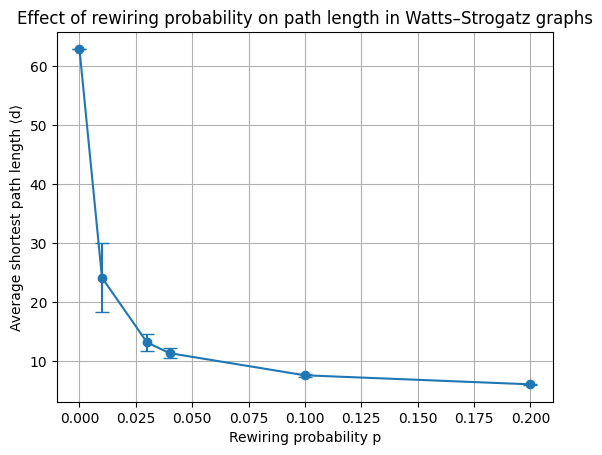

In [4]:
import matplotlib.pyplot as plt

# Parameters
N = 500
k = 4
p_values = [0, 0.01, 0.03, 0.04, 0.1, 0.2]
num_runs = 50

means = []
stds = []

for p in p_values:
    lengths = []
    for _ in range(num_runs):
        G = nx.watts_strogatz_graph(N, k, p)
        lengths.append(nx.average_shortest_path_length(G))
    means.append(np.mean(lengths))
    stds.append(np.std(lengths))

# Plot with error bars
plt.errorbar(p_values, means, yerr=stds, fmt='o-', capsize=5)
plt.xlabel("Rewiring probability p")
plt.ylabel("Average shortest path length ⟨d⟩")
plt.title("Effect of rewiring probability on path length in Watts–Strogatz graphs")
plt.grid(True)
plt.show()


### BA edition

*What are the three slope dependent regimes of complex networks with power-law degree distributions? Briefly describe each one. (You will have to skim chp 4.7 to answer this one).*


Complex networks with power-law degree distributions show three slope-dependent regimes, depending on the value of the exponent γ in P(k) ~ k^(-γ):

1. **γ > 3 (Weakly scale-free)**
   The degree distribution has a well-defined average and variance. Hubs are rare, and the network looks more like a classical random graph.

2. **2 < γ < 3 (Scale-free)**
   The average degree is finite, but the variance diverges. This means there can be extremely highly connected nodes, and the network is strongly dominated by them.

3. **1 < γ < 2 (Ultra-scale-free)**
   Even the average degree diverges as the network grows. A few nodes grab an enormous fraction of all links, leading to extreme inequality in connectivity.


*What are the three regimes we find in non-linear preferential attachement? (chapter 5) Briefly describe each one.*

Non-linear preferential attachment leads to three regimes, depending on how strongly the attachment probability grows with node degree:

1. **Sublinear attachment (α < 1)**
   High degree nodes have less advantage. The network becomes more homogeneous, with degrees spread narrowly and no dominant nodes.

2. **Linear attachment (α = 1)**
   This is the classic scale-free case. The network follows a power-law degree distribution, with a few very highly connected nodes and many low-degree ones.

3. **Superlinear attachment (α > 1)**
   A "winner-takes-all" effect appears. One nodes capture a giant share of all links, creating a star-like network dominated by a single hub.


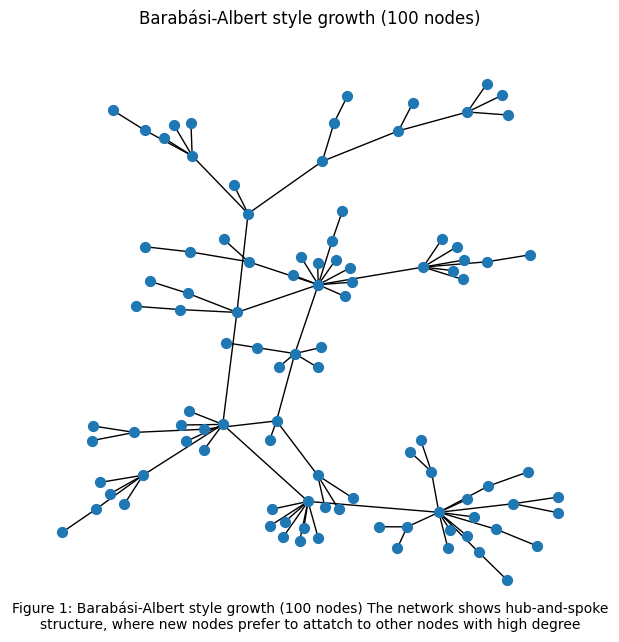

Max degree: 111
Min degree: 1


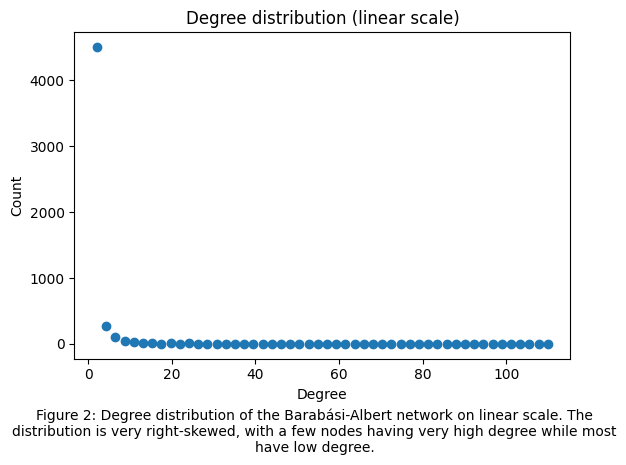

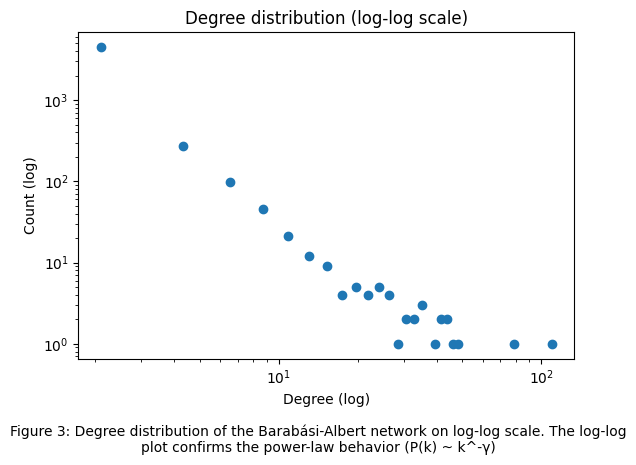

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np

# Step 1: Start with a single link
G = nx.Graph()
G.add_edge(0, 1)  # initial two nodes with one edge


# Step 2: Function to pick a node proportional to its degree 
def choose_node_by_degree(G):
    """
    Selects a node with probability proportional to its degree.
    Creates a list of nodes where each node appears as many times as its degree.
    Then picks randomly from this list.
    """
    nodes_by_degree = []
    for node, degree in G.degree():
        nodes_by_degree.extend([node] * degree)
    return random.choice(nodes_by_degree)


# Step 3: Grow the network to 100 nodes 
for new_node in range(2, 100):
    target = choose_node_by_degree(G)
    G.add_edge(new_node, target)

# Plot the small network (100 nodes)
plt.figure(figsize=(6, 6))
plt.figtext(0.5, 0.01, "Figure 1: Barabási-Albert style growth (100 nodes) The network shows hub-and-spoke structure, where new nodes prefer to attatch to other nodes with high degree", ha="center", fontsize=10, wrap=True)
plt.subplots_adjust(bottom=0.15)
nx.draw(G, node_size=50, with_labels=False)
plt.title("Barabási-Albert style growth (100 nodes)")
plt.show()

# Step 4: Grow to 5000 nodes 
for new_node in range(100, 5000):
    target = choose_node_by_degree(G)
    G.add_edge(new_node, target)

# Step 5: Maximum and minimum degree 
degrees = [deg for _, deg in G.degree()]
print("Max degree:", max(degrees))
print("Min degree:", min(degrees))

# Step 6: Degree distribution as scatter plots 
hist, bin_edges = np.histogram(degrees, bins=50)

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Linear scatter plot
plt.scatter(bin_centers, hist, marker='o')
plt.xlabel("Degree")
plt.ylabel("Count")
plt.title("Degree distribution (linear scale)")
plt.figtext(0.5, 0.01, "Figure 2: Degree distribution of the Barabási-Albert network on linear scale. " \
"The distribution is very right-skewed, with a few nodes having very high degree while most have low degree.", ha="center", fontsize=10, wrap=True)
plt.subplots_adjust(bottom=0.2)
plt.show()

# Log-log scatter plot
plt.scatter(bin_centers, hist, marker='o')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Degree (log)")
plt.ylabel("Count (log)")
plt.title("Degree distribution (log-log scale)")
plt.figtext(0.5, 0.01, "Figure 3: Degree distribution of the Barabási-Albert network on log-log scale. " \
            "The log-log plot confirms the power-law behavior (P(k) ~ k^-γ)", ha="center", fontsize=10, wrap=True)
plt.subplots_adjust(bottom=0.20)
plt.show()


# Assignment 1.2

In this part we will go start out by explaining how we build and modified the Graph with all the rock artists. Then we will do some analysis on the network and finally some visualizations  *

### Explanation of the Build Process for the Network

We built the rock performers network through the following steps:

**Data Collection:**
We started by fetching the wikitext page of the "List of Mainstream Rock Performers". This gave us a lot of unnecessary information, when we only really needed the links. Therefore, using a regex pattern, we created a new txt file with only the list of performers.

**Page Download:**
After collecting the list of all the performers, we proceeded to make a new directory and download all the individual artists' pages into individual .txt files. For this step, we encountered some issues with some artists having special characters in their names, which are not valid for filenames, such as "AC/DC" and "Panic! at the Disco", where "/" and "!" are not valid in filenames. Therefore, we needed to sanitize these by replacing them with "_". This turned out to help us in the end, since bands with whitespaces in their names have "_" in the Wikipedia URL.

**Link Extraction:**
To extract the links on each of the artists' wiki-pages, we used a regex pattern to look for the specific "[[...]]" or "[[...|...]]" format. Furthermore, we made sure to save these in a 'set' to avoid duplicate links, since we do not care about how *many* times artists are linked, just the fact that they *are*.

**Network Construction:**
To create the network:
- We started by initializing a directed graph (G)
- Looping over all performers in our list, for each performer we did the following:
  - Added the performer's name to G as a node
  - Used our helper function to count the number of words on their page and set this as "content_length"
  - Used our link extraction function to extract the links, making sure to filter any links which do not point to another artist
  - Finally, created directed edges to the other nodes corresponding to the links between performers
- The resulting network had 488 nodes and 7,267 edges

**Network Cleaning:**
We also inspected the network to identify any performers who are not linked to any other performers - there turned out to be 4 of those, so we removed them from the graph.

**Most Difficult Part**

The most difficult part was setting up the Wikipedia download and figuring out why we couldn't save some of the performers' wiki-text to a file. Furthermore, getting the regex just right also took some trial and error. Finally, because we changed some of the artist names in our list, we had trouble downloading their content, so we needed to "convert" their names to match their URL names.

**Use of LLMs**

For the network build, we used LLMs to help set up the API. We had some errors with 403 Forbidden, since we initially did not have a header for our API call. Furthermore, we had help developing the regex pattern and finally also help with the filename sanitization and following reconstruction for downloading the pages.

**What We Would Do Differently**

If we had to do this again, we would start with better research on how the data in Wikipedia is represented. We would also make a clearer mapping between our filenames and the actual URLs so that we did not need to deal with this issue. We might also benefit from better error handling, since we spent a fair bit of time trying to understand what was going wrong.

### Simple network analysis and statistics

**First we will fetch the graph from the github repository we made**

In [6]:
import networkx as nx
import requests
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO

# Download and load the network directly from GitHub
url = "https://raw.githubusercontent.com/Pakkutaq/SG_rock_network/main/rock_artists/rock_network.graphml"
response = requests.get(url)

G = nx.read_graphml(BytesIO(response.content))

### How many nodes and edges(links) are there in the network:

In [7]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print(f"Number of nodes in the network: {num_nodes}")
print(f"Number of edges in the network: {num_edges}")

Number of nodes in the network: 484
Number of edges in the network: 7267


### In- and Out degress of each nodes with plotting:

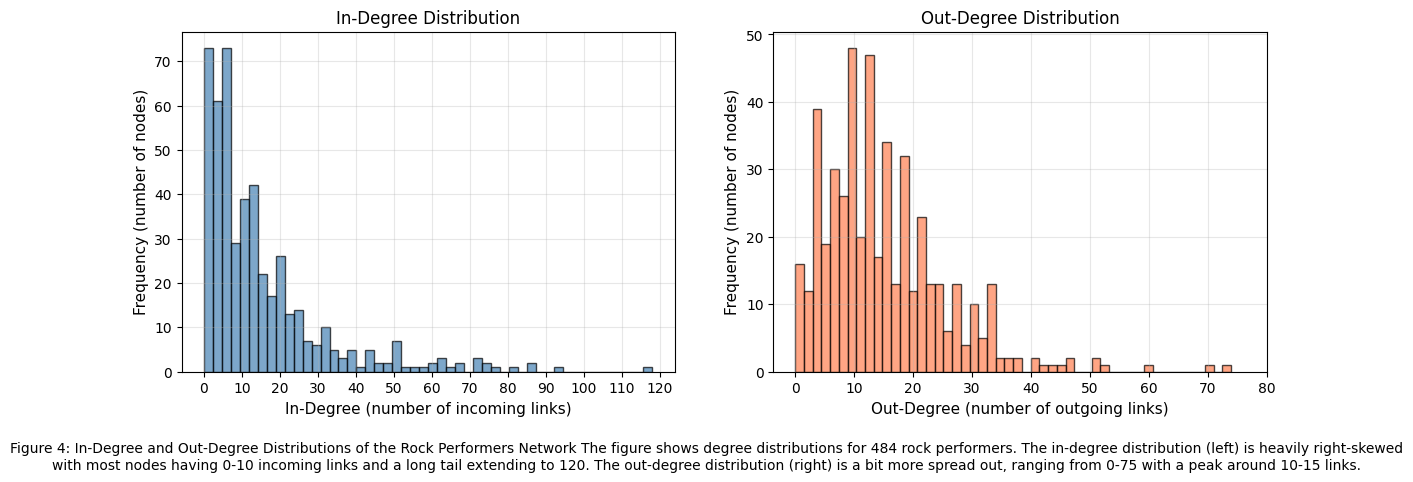

In [8]:
# Get in-degrees and out-degrees of all nodes
in_degrees = [degree for node, degree in G.in_degree()]
out_degrees = [degree for node, degree in G.out_degree()]

# Creating the subplot structure to compare in- and out-degrees
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot for in-degree
axs[0].hist(in_degrees, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axs[0].set_xlabel('In-Degree (number of incoming links)', fontsize=11)
axs[0].set_ylabel('Frequency (number of nodes)', fontsize=11)
axs[0].set_title('In-Degree Distribution')
axs[0].grid(True, alpha=0.3)
axs[0].set_xticks(range(0, max(in_degrees)+10, 10))

# Plot for out-degree
axs[1].hist(out_degrees, bins=50, edgecolor='black', alpha=0.7, color='coral')
axs[1].set_xlabel('Out-Degree (number of outgoing links)', fontsize=11)
axs[1].set_ylabel('Frequency (number of nodes)', fontsize=11)
axs[1].set_title('Out-Degree Distribution')
axs[1].grid(True, alpha=0.3)
axs[1].set_xticks(range(0, max(out_degrees)+10, 10))

plt.figtext(0.5, 0.01, "Figure 4: In-Degree and Out-Degree Distributions of the Rock Performers Network " \
            "The figure shows degree distributions for 484 rock performers. The in-degree distribution (left) is heavily right-skewed with most nodes having 0-10 incoming links and a long tail extending to 120. " \
            "The out-degree distribution (right) is a bit more spread out, ranging from 0-75 with a peak around 10-15 links.", ha="center", fontsize=10, wrap=True)
plt.subplots_adjust(bottom=0.2)
plt.show()

**Observations and Explanation:**

The distributions differ because they measure different aspects of the network. 

In-degree counts how many other performers' pages link to a given performer, reflecting their popularity and influence. The long tail appears because some very famous performers get cited a large amount.

Out-degree counts how many other performers a given page links to, reflecting citation behavior. And because it's rather limited how many links to other performers each wikipedia page has, we clearly see it more distributed but in a smaller range.

### Comparison between out-degree of rocker performers and random graph

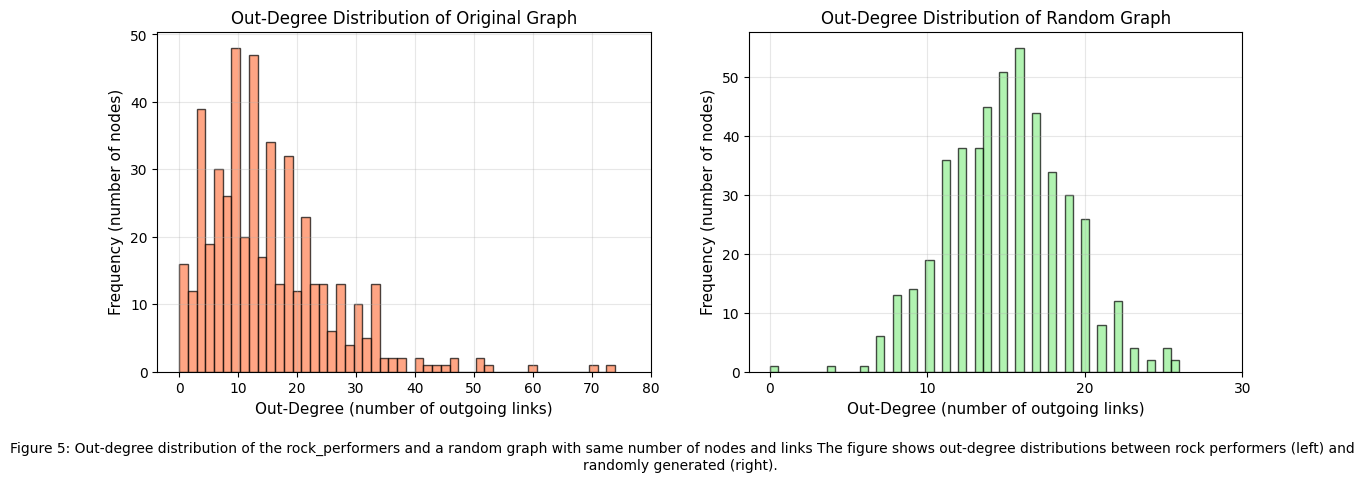

In [9]:
# Generating the random network with the same amount of nodes and links
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
random_graph = nx.gnm_random_graph(num_nodes, num_edges, directed=True)

# Comparing the out-degree to the random network
random_out_degrees = [degree for node, degree in random_graph.out_degree()]
G_out_degrees = [degree for node, degree in G.out_degree()]

fig, axs = plt.subplots(1, 2, figsize=(14, 5))
# Plot for out-degree of the original graph
axs[0].hist(G_out_degrees, bins=50, edgecolor='black', alpha=0.7, color='coral')
axs[0].set_xlabel('Out-Degree (number of outgoing links)', fontsize=11)
axs[0].set_ylabel('Frequency (number of nodes)', fontsize=11)
axs[0].set_title('Out-Degree Distribution of Original Graph')
axs[0].grid(True, alpha=0.3)
axs[0].set_xticks(range(0, max(G_out_degrees)+10, 10))  
# Plot for out-degree of the random graph
axs[1].hist(random_out_degrees, bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
axs[1].set_xlabel('Out-Degree (number of outgoing links)', fontsize=11)
axs[1].set_ylabel('Frequency (number of nodes)', fontsize=11)
axs[1].set_title('Out-Degree Distribution of Random Graph')
axs[1].grid(True, alpha=0.3)
axs[1].set_xticks(range(0, max(random_out_degrees)+10, 10))


plt.figtext(0.5, 0.01, "Figure 5: Out-degree distribution of the rock_performers and a random graph with same number of nodes and links " \
            "The figure shows out-degree distributions between rock performers (left) and randomly generated (right). ", ha="center", fontsize=10, wrap=True)
plt.subplots_adjust(bottom=0.2)
plt.show()


**Comparison**

We see a clear difference, the random graph follows a clear normal distribution, where the rock performers appear right-skewed in this scenario. Although, we notice, that the frequency between 10-20 outgoing edges, is not actually that different from eachother.

#### Comparison between in-degree and scale-free network:

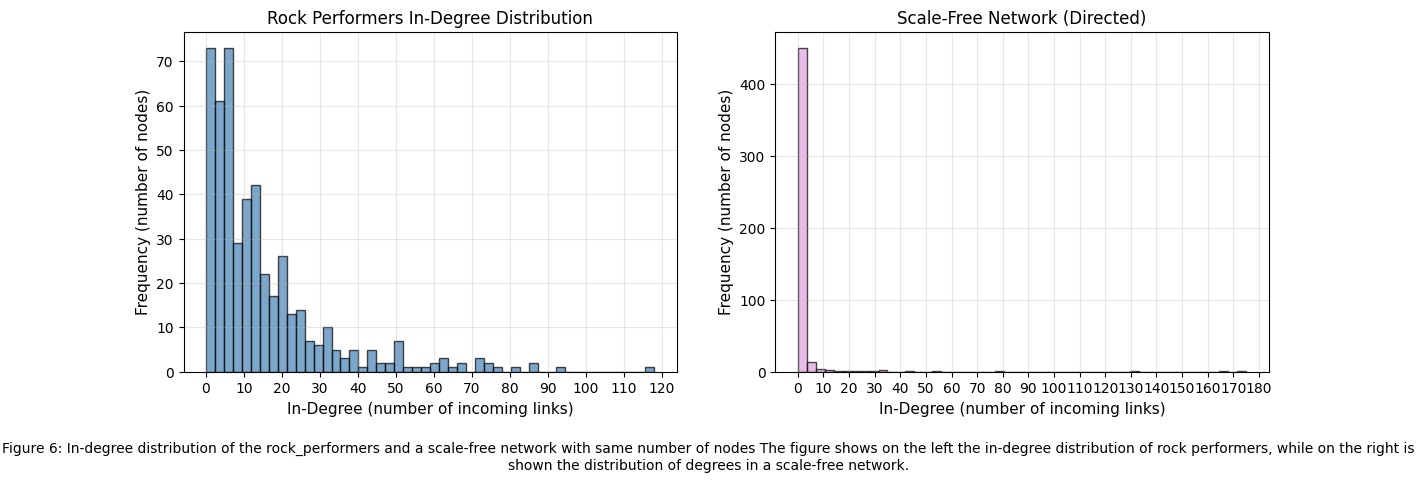

In [10]:
# Creating the scale-free network
scale_free_graph = nx.scale_free_graph(num_nodes)

# Get in-degrees for both networks
scale_free_in_degrees = [degree for node, degree in scale_free_graph.in_degree()]
G_in_degrees = [degree for node, degree in G.in_degree()]

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot for in-degree of the rock performers graph
axs[0].hist(G_in_degrees, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axs[0].set_xlabel('In-Degree (number of incoming links)', fontsize=11)
axs[0].set_ylabel('Frequency (number of nodes)', fontsize=11)
axs[0].set_title('Rock Performers In-Degree Distribution')
axs[0].grid(True, alpha=0.3)
axs[0].set_xticks(range(0, max(G_in_degrees)+10, 10))

# Plot for in-degree of the scale-free graph
axs[1].hist(scale_free_in_degrees, bins=50, edgecolor='black', alpha=0.7, color='plum')
axs[1].set_xlabel('In-Degree (number of incoming links)', fontsize=11)
axs[1].set_ylabel('Frequency (number of nodes)', fontsize=11)
axs[1].set_title('Scale-Free Network (Directed)')
axs[1].grid(True, alpha=0.3)
axs[1].set_xticks(range(0, max(scale_free_in_degrees)+10, 10))

plt.figtext(0.5, 0.01, "Figure 6: In-degree distribution of the rock_performers and a scale-free network with same number of nodes " \
            "The figure shows on the left the in-degree distribution of rock performers, while on the right is shown the distribution of degrees in a scale-free network.", ha="center", fontsize=10, wrap=True)
plt.subplots_adjust(bottom=0.2)
plt.show()

**Comparison and explanation**

In figure above there is a big difference between the distribution of the in-degree for rocker performers wiki-entires and a scale-free network. This is not surprising, since this distribution matches the one from part 1 of the assignment. However, they do share some similiarty, in that they both are right-skewed with long tails - the scale-free is more extreme in the right-skew.


### Top 5 most connected performers in terms of in- and out-degrees:

In [11]:
# Here we get the in- and out-degrees of all nodes as a dictionary, so we know which performer has which degree
in_degree_dict = dict(G.in_degree())
out_degree_dict = dict(G.out_degree())

# Sort by degree and select the top 5. We reverse the sorting since we want DESC order.
top_5_in_degree = sorted(in_degree_dict.items(), key=lambda x: x[1], reverse=True)[:5]
top_5_out_degree = sorted(out_degree_dict.items(), key=lambda x: x[1], reverse=True)[:5]

# Now we can prin the results
print("Top 5 performers by In-Degree:")
for performer, degree in top_5_in_degree:
    print(f"{performer}: {degree}")

print("\nTop 5 performers by Out-Degree:")
for performer, degree in top_5_out_degree:
    print(f"{performer}: {degree}")

# For our hypothesis, we expected out-degree to be somewhat correlated with page length (word count)
content_lengths = nx.get_node_attributes(G, 'content_length')

top_5_content_length = sorted(content_lengths.items(), key=lambda x: x[1], reverse=True)[:5]

print("\nTop 5 performers by Content Length (word count):")
for performer, length in top_5_content_length:
    print(f"{performer}: {length}")


Top 5 performers by In-Degree:
Led Zeppelin: 118
Bob Dylan: 93
Queen (band): 87
Metallica: 85
David Bowie: 81

Top 5 performers by Out-Degree:
Alice in Chains: 74
Deep Purple: 71
Black Sabbath: 60
Def Leppard: 52
Guns N' Roses: 51

Top 5 performers by Content Length (word count):
Bob Dylan: 20156
Paul McCartney: 19619
Elvis Presley: 18183
The Beach Boys: 18123
Queen (band): 16997


Looking at the output from above, there is really no surprise in in-degree. Every name in the top 5 are well-known bands which have been known and existed for a very long time, therefore it makes sense that a lot of other performer wiki-pages are linking to these. 

However, the top 5 out-degree performers (Alice in Chains, Deep Purple, Def Leppard) are surprising since they aren't the most iconic bands. This reveals that out-degree reflects page structure rather than fame - well-maintained contextual pages link to more artists, while famous bands' pages focus on their own story. We expected overlap with word count (longer pages = more links), but found none. The longest pages belong to the most famous performers, indicating that page length measures cultural significance and has no immediate affect the out-degree.

#### The longest wiki-entries
Finally we take a close look at the top 5 performers by content length.

In [12]:
top_10_content_length = sorted(content_lengths.items(), key=lambda x: x[1], reverse=True)[:10]

print("\nTop 10 performers by Content Length (word count):")
for performer, length in top_10_content_length:
    print(f"{performer}: {length}")



Top 10 performers by Content Length (word count):
Bob Dylan: 20156
Paul McCartney: 19619
Elvis Presley: 18183
The Beach Boys: 18123
Queen (band): 16997
David Bowie: 16738
The Beatles: 16670
The Rolling Stones: 16651
Frank Zappa: 16096
U2: 16081


As we also concluded in our hypothesis from above, the largest wiki-entries belong to some of the most well-known rock artists throughout time.

## Visualizing the networks

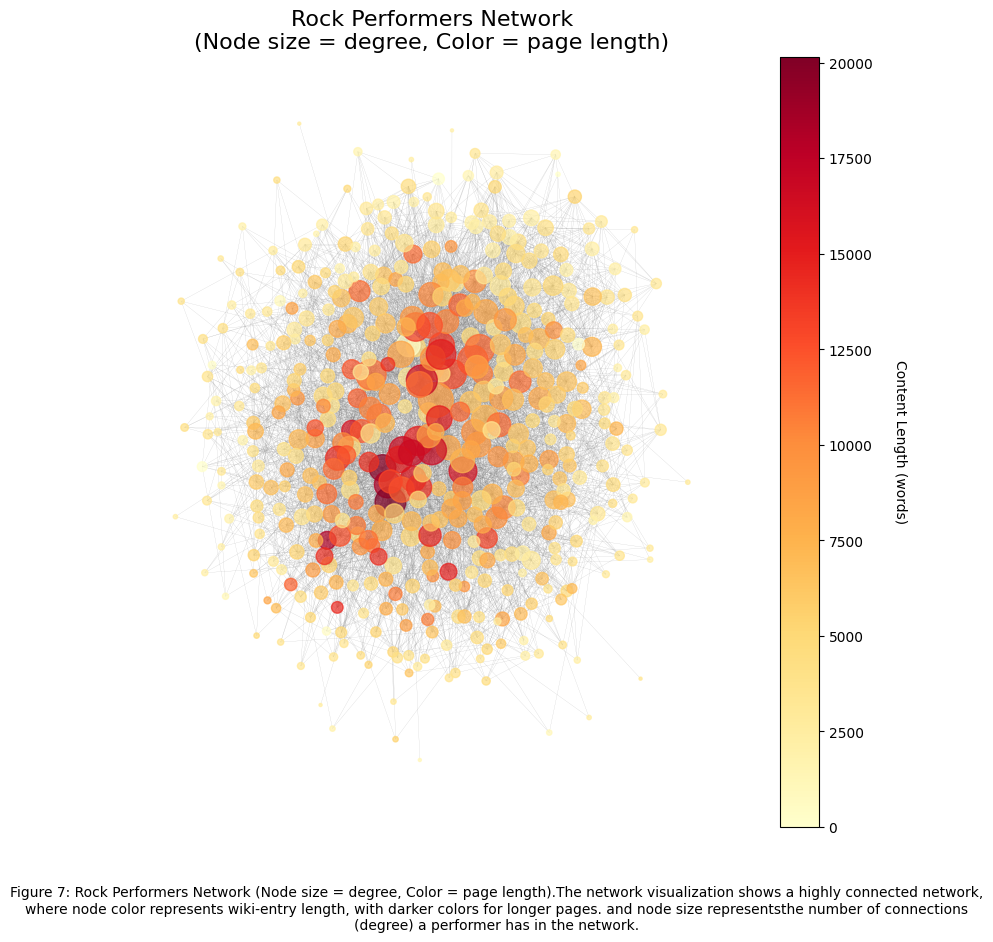

In [13]:
# Convert to undirected graph for visualization
G_undirected = G.to_undirected()

# Get node attributes we want degrees for size and content length for color
degrees = dict(G_undirected.degree())
content_lengths = nx.get_node_attributes(G, 'content_length')

plt.figure(figsize=(10, 10))

# Use Kamada-Kawai layout
# https://en.wikipedia.org/wiki/Force-directed_graph_drawing 
# https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.kamada_kawai_layout.html
pos = nx.kamada_kawai_layout(G_undirected) 

# Making the node sizes depend on the degree with a scalar for visibility
node_sizes = [degrees[node] * 5 for node in G_undirected.nodes()]

# Making the node colors depend on the content length with a scalar for visibility
node_colors = [content_lengths.get(node, 0) for node in G_undirected.nodes()]

# Draw the network
nx.draw_networkx(
    G_undirected,
    pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.YlOrRd,
    with_labels=False,
    edge_color='gray',
    alpha=0.7,
    width=0.1
)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.YlOrRd, norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('Content Length (words)', rotation=270, labelpad=25)

plt.title('Rock Performers Network\n(Node size = degree, Color = page length)', fontsize=16)
plt.axis('off')
plt.figtext(0.5, 0.01, "Figure 7: Rock Performers Network (Node size = degree, Color = page length)." \
"The network visualization shows a highly connected network, where node color represents wiki-entry length, with darker colors for longer pages. and node size represents" \
"the number of connections (degree) a performer has in the network.", ha="center", fontsize=10, wrap=True)
plt.show()

We observe that longer pages generally correspond to higher connectivity, as shown by the large, dark red nodes in the network's center. However, notable exceptions exist: several dark red nodes (long Wikipedia pages) appear with small sizes away from the center. These likely represent highly famous performers whose pages focus on their own story rather than linking to other artists. Some moderately-sized nodes near the center show the opposite pattern - shorter pages but high connectivity - suggesting these performers' Wikipedia entries are written with more emphasis on musical relationships and influences.

### Contributions

This Assignment was made by Oliver Badike Hansen (s224754) and Marcus Lilleør Christoffersen (s224750), and the contributions are distributed 50/50 as follows:

    - Oliver (s224754) made the Assignment 1.1
    - Marcus (s224750) made the Assignment 1.2